# Booking.com trip recommendation part 2 - EDA
> Booking.com challenge on trip recommendation part 2

- toc: true
- badges: true
- comments: true
- categories: [travel, eda]
- image: 

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
%matplotlib inline

sns.set_theme(style="ticks")

In [ ]:
!wget https://github.com/sparsh-ai/reco-data/raw/master/BookingChallenge.zip
!unzip BookingChallenge.zip

In [16]:
df = pd.read_csv('train_set.csv',
                 dtype={"user_id": str, "city_id": str, 
                        'affiliate_id': str, 'utrip_id': str},
                 date_parser=['checkin', 'checkout'])

df.head()

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id
0,1000027,2016-08-13,2016-08-14,8183,desktop,7168,Elbonia,Gondal,1000027_1
1,1000027,2016-08-14,2016-08-16,15626,desktop,7168,Elbonia,Gondal,1000027_1
2,1000027,2016-08-16,2016-08-18,60902,desktop,7168,Elbonia,Gondal,1000027_1
3,1000027,2016-08-18,2016-08-21,30628,desktop,253,Elbonia,Gondal,1000027_1
4,1000033,2016-04-09,2016-04-11,38677,mobile,359,Gondal,Cobra Island,1000033_1


In [17]:
df['checkin']  = pd.to_datetime(df['checkin'])
df['checkout'] = pd.to_datetime(df['checkout'])
df['duration'] = (df['checkout'] - df['checkin']).dt.days

df_group_checkin = df.groupby('checkin').agg({'user_id': 'count', 'duration': 'mean'})
df_group_checkin['duration_7d'] = df_group_checkin['duration'].rolling(window=7).mean()

df_group_checkin.head()

,user_id,duration,duration_7d
checkin,,,
2015-12-31,3,1.000000,NaN
2016-01-01,53,1.226415,NaN
2016-01-02,123,1.430894,NaN
2016-01-03,171,1.339181,NaN
2016-01-04,258,1.472868,NaN


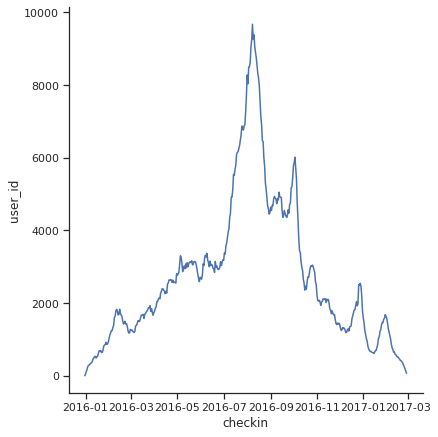

In [21]:
g = sns.relplot(data=df_group_checkin, x="checkin", y="user_id", kind="line", height=6)

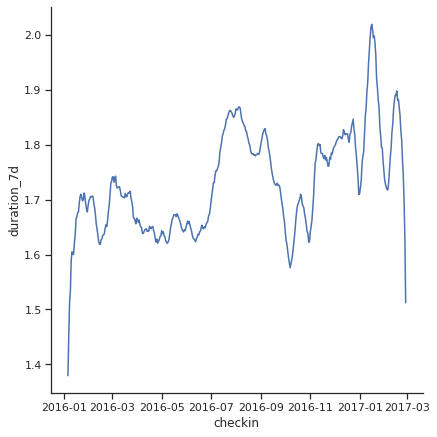

In [22]:
g = sns.relplot(data=df_group_checkin, x="checkin", y="duration_7d", kind="line", height=6)

In [23]:
df = df.iloc[0:1000]

df['checkin_month']      = df.checkin.dt.month
df['checkin_dayofweek']  = df.checkin.dt.dayofweek
df['checkin_quarter']    = df.checkin.dt.quarter
df['checkin_is_weekend'] = df.checkin.apply(lambda x : 1 if x.day_name in ['Saturday','Sunday'] else 0)

df['checkin_str']  = df['checkin'].astype(str)
df['checkout_str']  = df['checkout'].astype(str)
df['step'] = 1
df['step']= df.groupby(['utrip_id']).step.cumsum()

df.head()

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,duration,checkin_month,checkin_dayofweek,checkin_quarter,checkin_is_weekend,checkin_str,checkout_str,step
0,1000027,2016-08-13,2016-08-14,8183,desktop,7168,Elbonia,Gondal,1000027_1,1,8,5,3,0,2016-08-13,2016-08-14,1
1,1000027,2016-08-14,2016-08-16,15626,desktop,7168,Elbonia,Gondal,1000027_1,2,8,6,3,0,2016-08-14,2016-08-16,2
2,1000027,2016-08-16,2016-08-18,60902,desktop,7168,Elbonia,Gondal,1000027_1,2,8,1,3,0,2016-08-16,2016-08-18,3
3,1000027,2016-08-18,2016-08-21,30628,desktop,253,Elbonia,Gondal,1000027_1,3,8,3,3,0,2016-08-18,2016-08-21,4
4,1000033,2016-04-09,2016-04-11,38677,mobile,359,Gondal,Cobra Island,1000033_1,2,4,5,2,0,2016-04-09,2016-04-11,1


In [24]:
def count_hotel(hotel_country):
    return len(list(np.unique(hotel_country)))

def list_without_last(itens):
    return list(itens[:-1])

def list_without_last_and_pad(pad=5, dtype=int):
    def add_pad(items): 
        arr = list_without_last(items)
        arr = list(([dtype(0)] * (pad - len(arr[-pad:])) + arr[-pad:])) 
        return arr
    return add_pad

In [40]:
df_trip = df.sort_values(['checkin']).groupby(['utrip_id']).agg(
    user_id=('user_id', 'first'),
    count_unique_city=('city_id', count_hotel),
    trip_size=('checkin', len),
    start_trip=('checkin', 'first'),
    checkin_list=('checkin_str', list_without_last_and_pad(5, str)),
    checkout_list=('checkout', list_without_last_and_pad(5)),
    duration_list=('duration', list_without_last_and_pad(5, int)),
    city_id_list=('city_id', list_without_last_and_pad(5, str)),
    device_class_list=('device_class', list_without_last_and_pad(5, str)),
    affiliate_id_list=('affiliate_id', list_without_last_and_pad(5, str)),
    booker_country_list=('booker_country', list_without_last_and_pad(5, str)),
    hotel_country_list=('hotel_country', list_without_last_and_pad(5, str)),
    step_list=('step', list_without_last_and_pad(5, int)),
    last_city_id=('city_id', 'last')
)

df_trip['end_trip']  = df_trip['checkout_list'].apply(lambda x: x[-1] if len(x) > 1 else None)
df_trip = df_trip.loc[df_trip['end_trip']!=0,:]
df_trip['end_trip'] = pd.to_datetime(df_trip['end_trip'])
df_trip['duration']  = (df_trip['end_trip'] - df_trip['start_trip']).dt.days

df_trip.head()

,user_id,count_unique_city,trip_size,start_trip,checkin_list,checkout_list,duration_list,city_id_list,device_class_list,affiliate_id_list,booker_country_list,hotel_country_list,step_list,last_city_id,end_trip,duration
utrip_id,,,,,,,,,,,,,,,,
1000027_1,1000027,4,4,2016-08-13,"[0, 0, 2016-08-13, 2016-08-14, 2016-08-16]","[0, 0, 2016-08-14 00:00:00, 2016-08-16 00:00:0...","[0, 0, 1, 2, 2]","[0, 0, 8183, 15626, 60902]","[0, 0, desktop, desktop, desktop]","[0, 0, 7168, 7168, 7168]","[0, 0, Elbonia, Elbonia, Elbonia]","[0, 0, Gondal, Gondal, Gondal]","[0, 0, 1, 2, 3]",30628,2016-08-18,5
1000033_1,1000033,4,5,2016-04-09,"[0, 2016-04-09, 2016-04-11, 2016-04-12, 2016-0...","[0, 2016-04-11 00:00:00, 2016-04-12 00:00:00, ...","[0, 2, 1, 2, 2]","[0, 38677, 52089, 21328, 27485]","[0, mobile, desktop, desktop, desktop]","[0, 359, 384, 384, 384]","[0, Gondal, Gondal, Gondal, Gondal]","[0, Cobra Island, Cobra Island, Cobra Island, ...","[0, 1, 2, 3, 4]",38677,2016-04-16,7
1000045_1,1000045,7,7,2016-06-18,"[2016-06-20, 2016-06-22, 2016-06-24, 2016-06-2...","[2016-06-22 00:00:00, 2016-06-24 00:00:00, 201...","[2, 2, 1, 1, 2]","[55128, 9608, 31817, 36170, 58178]","[desktop, desktop, desktop, mobile, mobile]","[7974, 7974, 7974, 359, 359]","[The Devilfire Empire, The Devilfire Empire, T...","[Fook Island, Fook Island, Carpathia, Carpathi...","[2, 3, 4, 5, 6]",36063,2016-06-28,10
1000083_1,1000083,4,4,2016-06-13,"[0, 0, 2016-06-13, 2016-06-14, 2016-06-15]","[0, 0, 2016-06-14 00:00:00, 2016-06-15 00:00:0...","[0, 0, 1, 1, 1]","[0, 0, 55990, 14705, 35160]","[0, 0, mobile, mobile, mobile]","[0, 0, 359, 359, 359]","[0, 0, The Devilfire Empire, The Devilfire Emp...","[0, 0, Osterlich, Osterlich, Osterlich]","[0, 0, 1, 2, 3]",36063,2016-06-16,3
100008_1,100008,5,5,2016-07-18,"[0, 2016-07-18, 2016-07-21, 2016-07-22, 2016-0...","[0, 2016-07-21 00:00:00, 2016-07-22 00:00:00, ...","[0, 3, 1, 1, 2]","[0, 11306, 12096, 6761, 6779]","[0, desktop, desktop, desktop, desktop]","[0, 8436, 8436, 8436, 8436]","[0, Gondal, Gondal, Gondal, Gondal]","[0, Kamistan, Kamistan, Kamistan, Kamistan]","[0, 1, 2, 3, 4]",65690,2016-07-25,7


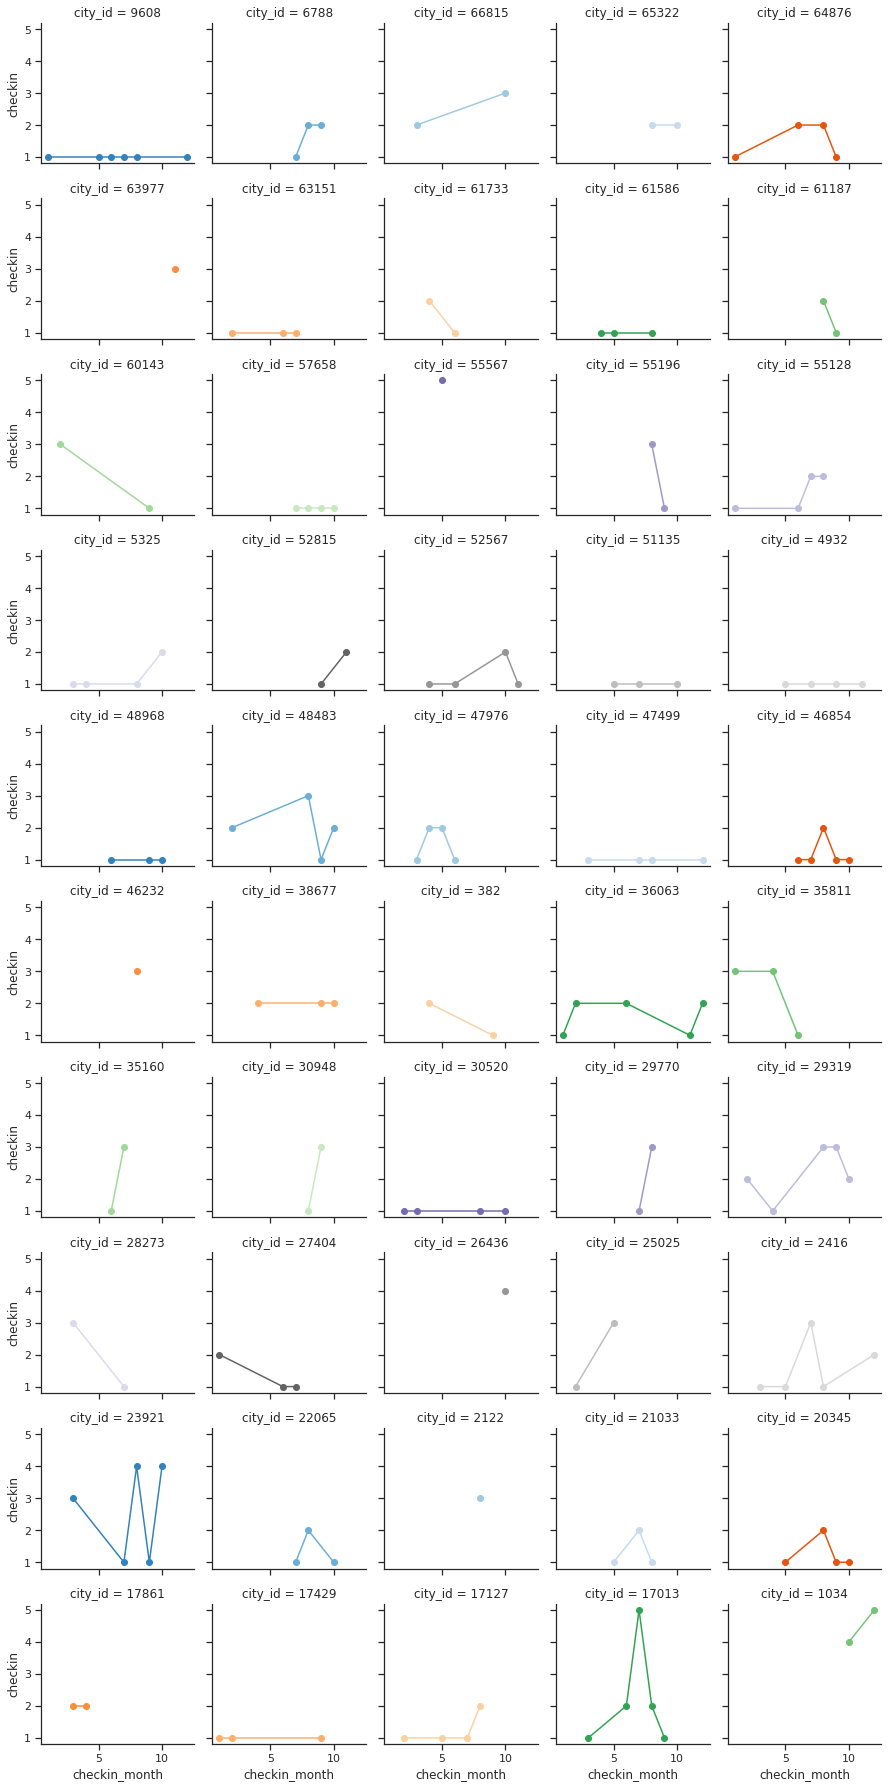

In [43]:
df_city_group = df.groupby('city_id').agg({'checkin': 'count', 'duration': 'mean'})\
                    .sort_values('checkin',ascending=False)

df_city_month_group = df.groupby(['city_id', 'checkin_month']).agg({'checkin': 'count', 'duration': 'mean'})\
                    .reset_index().sort_values(['city_id', 'checkin_month', 'checkin'],ascending=False)

city_idx = list(df_city_group.index)[:50]

df_plot  = df_city_month_group[df_city_month_group.city_id.isin(city_idx)]

grid     = sns.FacetGrid(df_plot, col="city_id", hue="city_id", palette="tab20c",
                     col_wrap=5, height=2.5)
grid.map(plt.plot, "checkin_month", "checkin", marker="o")
grid.fig.tight_layout(w_pad=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


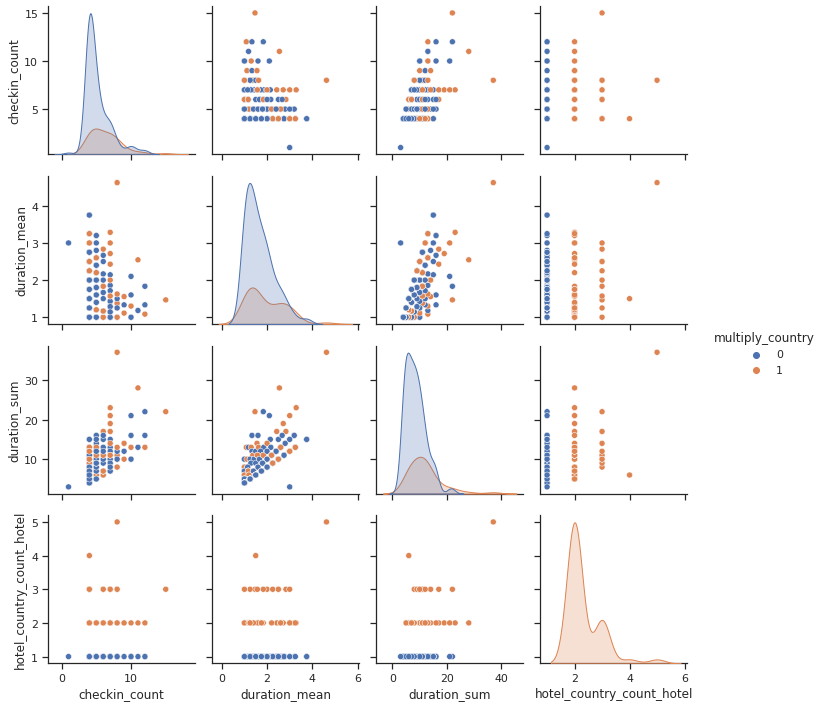

In [44]:
def count_hotel(hotel_country):
    return len(list(np.unique(hotel_country)))

def join_city(city):
    return "_".join(list(city))

df_utrip_id_group = df.groupby('utrip_id').agg({'checkin': 'count', 
                                                'duration': ['mean', 'sum'], 
                                                'hotel_country': count_hotel,
                                                'city_id': join_city})
df_utrip_id_group.columns = ["_".join(pair) for pair in df_utrip_id_group.columns]
df_utrip_id_group = df_utrip_id_group.sort_values('checkin_count', ascending=False)

df_utrip_id_group['multiply_country'] = (df_utrip_id_group['hotel_country_count_hotel'] > 1).astype(int)

sns.pairplot(df_utrip_id_group, hue="multiply_country")